This notebook tests a CNN training network and constructs a centralised baseline for the MNIST dataset

In [51]:
from datasets import load_dataset
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

In [58]:
# Load Dataset
dataset = load_dataset("mnist").with_format("torch")
train = dataset["train"]
test = dataset["test"]
train_dataloader = DataLoader(train, batch_size=32)
test_dataloader = DataLoader(test, batch_size=32)

Feature shape: torch.Size([28, 28]) | Label 5


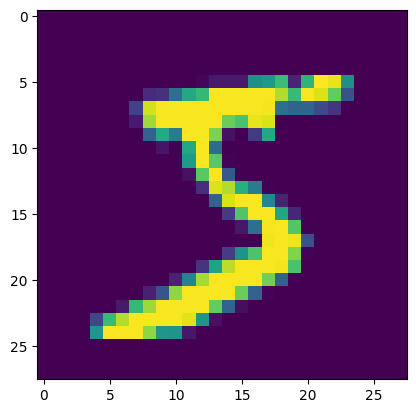

In [59]:
# Visualise data
sample_feature, sample_label = train[0]['image'], train[0]["label"]
plt.imshow(sample_feature)
print(f"Feature shape: {sample_feature.shape} | Label {sample_label}")

In [60]:
import torch
from torch import nn

class MnistClassifier(nn.Module):
    """ This class defines a basic convolutional neural nework
    """
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=3),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=3),
        nn.Conv2d(in_channels=16,out_channels=32, kernel_size=3, padding=3),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3, padding=3),
        nn.LeakyReLU()
        )
        self.flatten = nn.Flatten(start_dim=-3, end_dim=-1)
        self.mlp = nn.Sequential(
            nn.LazyLinear(out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=10)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(torch.float32)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.mlp(x)
        return x

net = MnistClassifier()
net(sample_feature.unsqueeze(0))

/home/markhaoxiang/Projects/fl/ros2_flower_rl/venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([-1.3015, -0.1431, -0.5311, -0.0272,  1.0314, -1.4497, -1.1389,  0.0669,
        -1.7409,  1.0527], grad_fn=<ViewBackward0>)

In [66]:
# Train the Classifier
torch.manual_seed(0)
net = MnistClassifier()
cross_entropy_loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters())

losses = []
for epoch in tqdm(range(10)):
    c = 0
    for batch in train_dataloader:
        c+=1
        if c > 50:
            break
        X, y = batch["image"], batch["label"]
        # Normalisation step
        X = (X / 256).unsqueeze(-3)
        # Predict Labels
        py = net(X)
        # Loss
        loss = cross_entropy_loss(py, y)
        # Step
        optim.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optim.step()

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


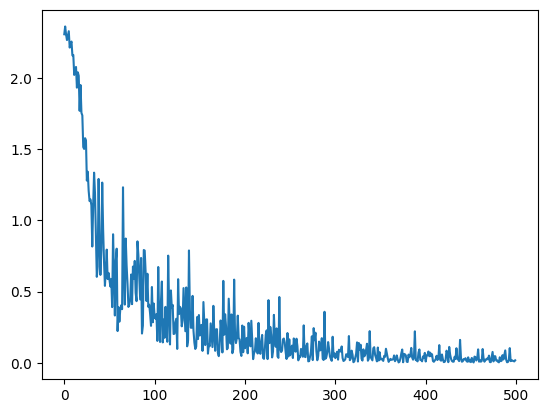

In [67]:
plt.plot(losses)